In [1]:
## This file generates plots for the paper for the latest bolt urdf
import numpy as np
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from matplotlib.patches import Ellipse, Rectangle


#for live plotting
from IPython.display import clear_output
from matplotlib import pyplot as plt
%matplotlib inline

%run 3d_ipm_env.ipynb #imports LIPM Env

[0.5 0. ] 0.4
[1. 0.] 100.4


In [2]:
# Lipm - 8 layers , 512 each
class NN(nn.Module):
    def __init__(self, inp_size, out_size):
        
        super(NN, self).__init__()
        self.l1 = nn.Linear(inp_size, 512)
        self.l2 = nn.Linear(512, 512)
        self.l3 = nn.Linear(512, 512)
        self.l4 = nn.Linear(512, 512)
        self.l5 = nn.Linear(512, 512)
        self.l6 = nn.Linear(512, 512)
        self.l7 = nn.Linear(512, 512)
        self.l8 = nn.Linear(512, out_size)
    
    def forward(self, x):
        
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = F.relu(self.l3(x))
        x = F.relu(self.l4(x))
        x = F.relu(self.l5(x))
        x = F.relu(self.l6(x))
        x = F.relu(self.l7(x))
        x = self.l8(x)
        return x

In [3]:
class DQStepper:
    def __init__(self, no_actions = [9, 7], lr = 1e-4, gamma = 0.9, use_tarnet = False, trained_model = None):
        '''
        This is a 3d dq stepper.
        State = [x-ux, y-uy, z-uz, xd, yd, n, action_x, action_y, action_z]
        '''
        self.device = torch.device("cpu")
        self.dq_stepper = NN(11, 1).to(self.device) #state+ action -> q_value
        if trained_model:
            self.dq_stepper.load_state_dict(torch.load(trained_model))
            self.dq_stepper.eval()
        self.optimizer = torch.optim.SGD(self.dq_stepper.parameters(), lr)
        self.use_tarnet = use_tarnet
        if self.use_tarnet:
            self.dq_tar_stepper = NN(11, 1).to(self.device)
            self.dq_tar_stepper.load_state_dict(self.dq_stepper.state_dict())
            self.dq_tar_stepper.eval()
        self.gamma = gamma #discount factor
        assert len(no_actions) == 2
        self.no_actions = no_actions
        
        # This is the template of x_in that goes into the dq stepper
        self.max_step_height = 0.00
        self.max_no = 5 #number of actions with non zero step in z
        self.x_in = np.zeros((self.no_actions[0]*self.no_actions[1], 11))
        self.x_in[:,8] = np.tile(np.arange(self.no_actions[0]), self.no_actions[1])
        self.x_in[:,9] = np.repeat(np.arange(self.no_actions[1]), self.no_actions[0])
                  
    def predict_action_value(self, x):
        # this function predicts the q_value for different actions and returns action and min q value
        self.x_in[:,[0, 1, 2, 3, 4, 5, 6, 7]] = x
        for e in np.random.randint(0, len(self.x_in), self.max_no):
            self.x_in[e, 10] = 2*self.max_step_height*(np.random.rand() - 0.5)
        torch_x_in = torch.FloatTensor(self.x_in, device = self.device)
        with torch.no_grad():
            q_values = self.dq_stepper(torch_x_in).detach().numpy()
            action_index = np.argmin(q_values)
            action_x = int(action_index%self.no_actions[0])
            action_y = int(action_index//self.no_actions[0])
            action_z = self.x_in[action_index,10]
        return [action_x, action_y, action_z], q_values[action_index]
    
    def tar_predict_action_value(self, x):
        # this function uses tar net to predict 
        # the q_value for different actions and returns action and min q value
        self.x_in[:,[0, 1, 2, 3, 4, 5, 6, 7]] = x
        for e in np.random.randint(0, len(self.x_in), self.max_no):
            self.x_in[e, 10] = 2*self.max_step_height*(np.random.rand() - 0.5)
        torch_x_in = torch.FloatTensor(self.x_in, device = self.device)
        with torch.no_grad():
            q_values = self.dq_tar_stepper(torch_x_in).detach().numpy()
            action_index = np.argmin(q_values)
            action_x = int(action_index%self.no_actions[0])
            action_y = int(action_index//self.no_actions[0])
            action_z = self.x_in[action_index,10]
        return [action_x, action_y, action_z], q_values[action_index]
    
    def predict_eps_greedy(self, x, eps = 0.1):
        # This function returns prediction based on epsillon greedy algorithm
        if np.random.random() > eps:
            return self.predict_action_value(x)[0]
        else:
            action_x = np.random.randint(self.no_actions[0])
            action_y = np.random.randint(self.no_actions[1])
            action_z = 2*self.max_step_height*(np.random.rand() - 0.5)
            
        return [action_x, action_y, action_z]
        
    def optimize(self, mini_batch, tau = 0.001):
        # This function performs one step of back propogation for the given mini_batch data
        x_in = torch.FloatTensor(mini_batch[:,0:11].copy(), device = self.device)
        y_train = torch.FloatTensor(mini_batch[:,11].copy(), device = self.device)
        for i in range(len(mini_batch)):
            if not np.isnan(mini_batch[i,12:]).all():
                if not self.use_tarnet:
                    y_train[i] += self.gamma * self.predict_action_value(mini_batch[i,12:])[1]
                else:
                    y_train[i] += self.gamma * self.tar_predict_action_value(mini_batch[i,12:])[1]

        y_train = y_train.unsqueeze(1).detach() #ensures that gradients are not computed on this
        x_train = self.dq_stepper(x_in)

        loss = F.mse_loss(x_train, y_train)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        if self.use_tarnet:
            for tar_param, param in zip(self.dq_tar_stepper.parameters(), self.dq_stepper.parameters()):
                tar_param.data.copy_(tar_param.data * (1.0 - tau) + param.data * tau)
                
        return loss
    
    def live_plot(self, history, e, figsize=(15,25), window = 500, title='history'):
        clear_output(wait=True)
        clear_output(wait=True)
        fig, ax = plt.subplots(3, 1, figsize=figsize)
        ax[0].plot(history['epi_cost'], label='epi_cost', color = 'orange')
        ax[0].grid(True)
        ax[0].legend() # the plot evolves to the right
        if e > window:
            ax[1].plot(np.arange(e-window+1, e), history['epi_cost'][e-window:], label='epi_cost zoom')
            ax[1].grid(True)
            ax[1].legend() # the plot evolves to the right
        ax[2].plot(history['loss'], label='loss', color = 'black')
        ax[2].grid(True)
        ax[2].legend() # the plot evolves to the right
        ax[2].set_ylim(0, 60)
        plt.xlabel('episode')
        plt.show();
        
    def predict_q(self, x, terrain):
        #for debugging
        # this function predicts the q_value for different actions and returns action and min q value
        self.x_in[:,[0, 1, 2, 3, 4, 5, 6, 7]] = x
        self.x_in[:,10] = terrain
        torch_x_in = torch.FloatTensor(self.x_in, device = self.device)
        with torch.no_grad():
            q_values = self.dq_stepper(torch_x_in).detach().numpy()
            action_index = np.argmin(q_values)
            action_x = int(action_index%self.no_actions[0])
            action_y = int(action_index//self.no_actions[0])
            action_z = self.x_in[action_index,10]
            
        return q_values, [action_x, action_y, action_z] 

In [4]:
# This is for 1d stepping case with DCM

ht = 0.35
max_step_length = [0.4, 0.0]
no_actions = [11, 1]
env = InvertedPendulumEnv(ht, 0.0, max_step_length, [0.5, 3, 1.5], no_actions)
no_actions = [len(env.action_space_x), len(env.action_space_y)]

dqs = DQStepper(lr=1e-4, gamma=0.98, use_tarnet= True, no_actions= no_actions, trained_model='../../models/dqs_x11')

print(no_actions)
print(env.action_space_x)
print(env.action_space_y)


[11, 1]
[-0.4  -0.32 -0.24 -0.16 -0.08  0.    0.08  0.16  0.24  0.32  0.4 ]
[0.]


In [15]:
## Plot for inverted pendulum env test (plannar walking)

no_steps = 10 ## number of steps simulated per episode (pendulum steps)
step_time = 0.2 ## time after which step is taken

v_init = [-0.2, 0]
# v_init = np.round([0.2*random.uniform(-1.0, 1.0), 0.2*random.uniform(-1.0, 1.0)], 2)

v_des = [0.0, 0.0]

print(v_init)
state = env.reset_env([0.0, 0.00, ht, v_init[0], v_init[1]], v_des, no_steps*step_time)
epi_cost = 0
history = {'state' : [], 'action' : [], 'next_state' : [], 'q_value' : []}
for n in range(no_steps):
    terrain = -0.00*(np.random.randint(-4, 5, no_actions[0]*no_actions[1]))/4.0
    q, action = dqs.predict_q(state, terrain)
    next_state, cost, done = env.step_env(action, step_time)
    history['state'].append(state)
    history['action'].append(action)
    history['next_state'].append(next_state)
    history['q_value'].append(q)
    print(action, state[3:5])
    epi_cost += cost
    state = next_state
    if done:
        print(epi_cost)
        break
        
# env.show_episode_side(10)

[-0.2, 0]
[3, 0, -0.0] [-0.2  0. ]
[7, 0, -0.0] [-0.32  0.  ]
[4, 0, 0.0] [0.23 0.  ]
[7, 0, 0.0] [0.01 0.  ]
[4, 0, -0.0] [0.32 0.  ]
[5, 0, 0.0] [-0.05  0.  ]
[6, 0, 0.0] [0.05 0.  ]
[5, 0, 0.0] [0.21 0.  ]
[6, 0, 0.0] [0.1 0. ]
[2, 0, 0.0] [0.1 0. ]


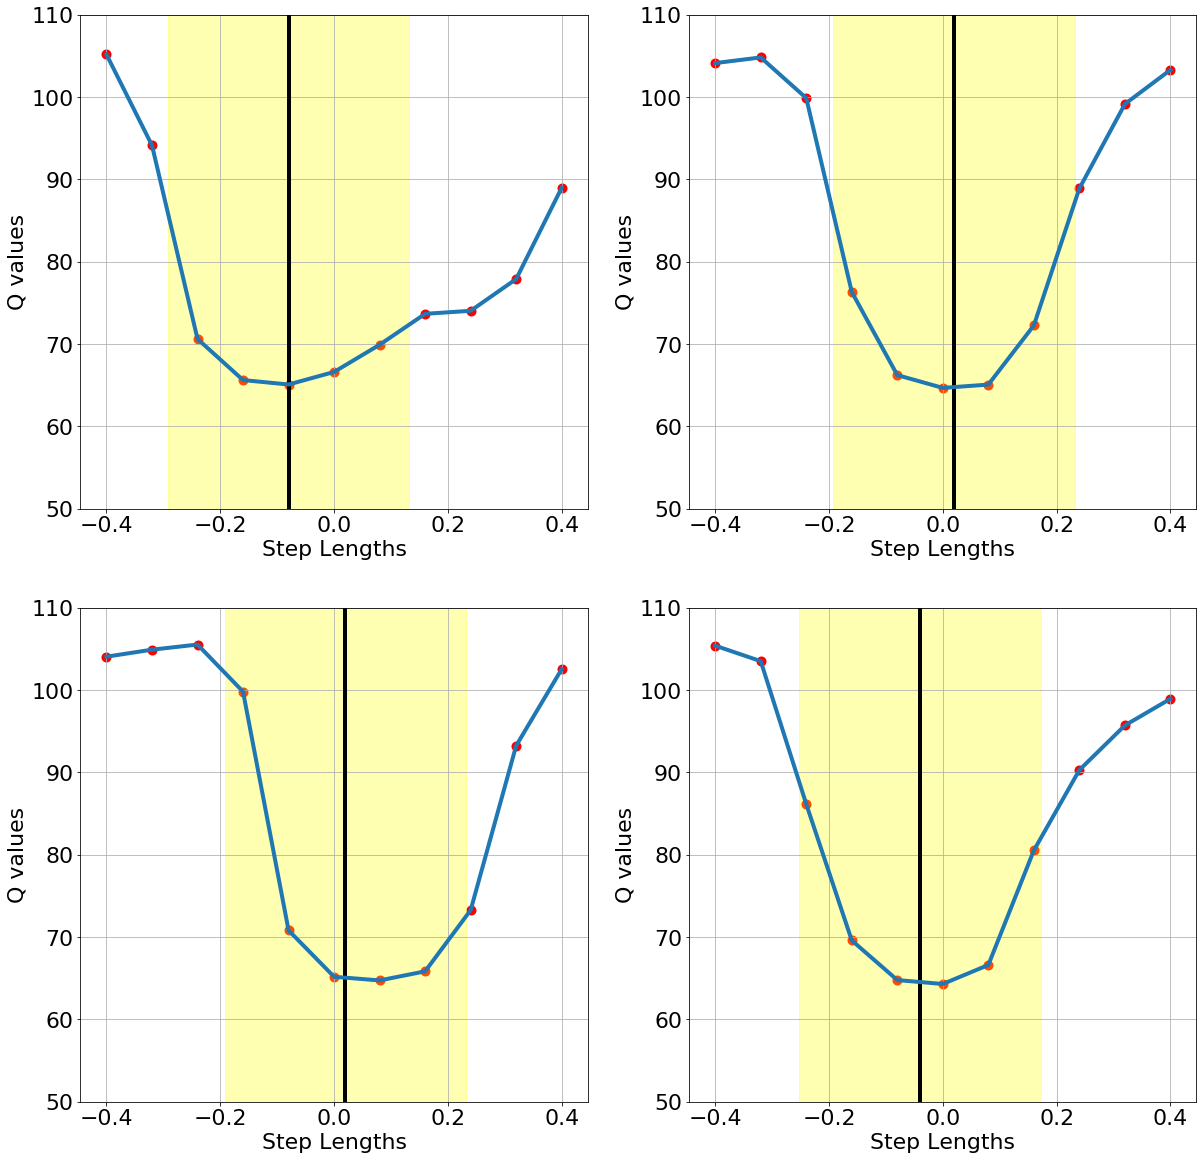

<Figure size 432x288 with 0 Axes>

In [27]:
def compute_dcm(state, ht):
    return state[0] + np.sqrt(ht/9.81)*state[1]

def infinite_capture_radius(step_time, max_step_length, ht):
    delta_t = np.sqrt(9.81/ht)*step_time
    return max_step_length*(np.power(np.e, -delta_t))/(1 - np.power(np.e, -delta_t))

def plot(history, env, start_step, end_step, ht):
    no_steps = end_step - start_step
    rad = infinite_capture_radius(0.2, 0.4, 0.35)
    fig, axs = plt.subplots(int(no_steps/2), 2, figsize = [20, 20])
    for i in range(0, int(no_steps/2)):
        plt.rcParams.update({'font.size': 22})
        capt_reg = Rectangle((compute_dcm(history["state"][2*i + start_step], ht)- rad,0) , 2*rad, 1000, color = "yellow", alpha = 0.3)
        axs[i, 0].add_patch(capt_reg)

        axs[i, 0].plot(env.action_space_x, history["q_value"][2*i + start_step],\
                       label = str(history["state"][2*i + start_step][0::3][0:2]), linewidth = 4)
        axs[i, 0].scatter(env.action_space_x, history["q_value"][2*i + start_step],\
                       label = str(history["state"][2*i + start_step][0::3][0:2]), linewidth = 4, color = "red")
        
        axs[i, 0].vlines(compute_dcm(history["state"][2*i + start_step], ht), 40, 130, label='ICP/DCM', linewidth = 4)
        
        axs[i, 1].plot(env.action_space_x, history["q_value"][2*i + start_step + 1],\
                       label = str(history["state"][2*i + start_step + 1][0::3][0:2]), linewidth = 4)
        
        
        capt_reg = Rectangle((compute_dcm(history["state"][2*i + start_step + 1], ht)- rad,0) , 2*rad, 1000, color = "yellow", alpha = 0.3)
        axs[i, 1].add_patch(capt_reg)
        
        axs[i, 1].vlines(compute_dcm(history["state"][2*i + start_step + 1], ht), 40, 130, label='ICP/DCM', linewidth = 4)
        axs[i, 1].scatter(env.action_space_x, history["q_value"][2*i + start_step + 1],\
                       label = str(history["state"][2*i + start_step + 1][0::3][0:2]), linewidth = 4, color = "red")
        
        axs[i, 0].set_ylim(50, 110)
        axs[i, 0].set_ylabel('Q values')
        axs[i, 0].set_xlabel('Step Lengths')
        axs[i, 1].set_ylim(50, 110)
        axs[i, 1].set_ylabel('Q values')
        axs[i, 1].set_xlabel('Step Lengths')
#         axs[i, 0].legend()    
#         axs[i, 1].legend()
        axs[i, 0].grid()
        axs[i, 1].grid()


    plt.show()
    plt.savefig('1D_LIPM_Q')

plot(history, env, 4, 8, env.h)


In [ ]:
ht = 0.35
max_step_length = [0.4, 0.3]
no_actions = [11, 9]
env = InvertedPendulumEnv(ht, 0.13, max_step_length, [0.5, 3, 1.5], no_actions)
no_actions = [len(env.action_space_x), len(env.action_space_y)]

dqs = DQStepper(lr=1e-4, gamma=0.98, use_tarnet= True, no_actions= no_actions, trained_model='../../models/dqs_11_9')

print(no_actions)
print(env.action_space_x)
print(env.action_space_y)

In [5]:
# This block is to compare cpature regions with analytical capture region
def compute_dcm(state, ht):
    return state[0] + np.sqrt(ht/9.81)*state[1]

def infinite_capture_radius(step_time, max_step_length, ht):
    delta_t = np.sqrt(9.81/ht)*step_time
    return max_step_length*(np.power(np.e, -delta_t))/(1 - np.power(np.e, -delta_t))

def plot_heatmap_with_capture_region(x, next_x, terr, dqs, env):
    plt.rcParams.update({'font.size': 15})
    q_1 = dqs.predict_q(x, terr)[0]
    n = dqs.no_actions
    q_mat = np.zeros((n[1], n[0]))
    for i in range(len(q_1)):
        q_mat[int(dqs.x_in[i,9]), int(dqs.x_in[i,8])] = q_1[i]
    
    dcm_x = compute_dcm([next_x1[0], next_x1[3]], env.h)
    dcm_y = compute_dcm([next_x1[1], next_x1[4]], env.h)
    fig, ax = plt.subplots(figsize = (10,5))
    rad = infinite_capture_radius(0.2, env.action_space_x[-1], env.h)
#     print(rad, dcm_x, dcm_y)
    discretization_x = env.action_space_x[1] - env.action_space_x[0]
    discretization_y = env.action_space_y[1] - env.action_space_y[0]
    
    # shifting by 0.5 becuase all the ticks should be in the center
    dcm_ind = (dcm_x/discretization_x + 5.5, dcm_y/discretization_y + 0.5)
    
    capture_region = Ellipse(dcm_ind, 2.0*(rad/(discretization_x))+0.5, 2.0*(rad/(discretization_y))+0.5, fill = False, color = 'red', lw = 2.5)
    
    dcm = plt.Circle(dcm_ind, 0.15, fill = True, color = 'red')
    # slightly adjusted because the indices are not center aligned i
    kin_region = Ellipse((next_x[0]/discretization_x + 6.2, next_x[1]/discretization_y),\
                            2*(np.sqrt(env.max_leg_length**2 - (env.h - env.com_offset)**2)/discretization_x),\
                         2*(np.sqrt(env.max_leg_length**2 - (env.h - env.com_offset)**2)/discretization_y), fill = False, color = 'yellow', lw = 2.5)
    ax.add_patch(capture_region)
    ax.add_patch(kin_region)
    ax.add_patch(dcm)
    ax.set_xticklabels(env.action_space_x[::2])
    ax.set_yticklabels(env.action_space_y)
    heatmap = ax.pcolor(q_mat, cmap='PuBu_r')
    ax.set_xlim(0,11)
    ax.set_ylim(0,9)
    
    ax.vlines(5, 4, 6, color = 'white', lw = 3)
    ax.vlines(5, 1, 2, color = 'white', lw = 3)
    ax.vlines(4, 2, 4, color = 'white', lw = 3)
    ax.vlines(9, 1, 6, color = 'white', lw = 3)

    ax.hlines(1, 5, 9, color = 'white', lw = 3 )    
    ax.hlines(2, 4, 5, color = 'white', lw = 3 )    
    ax.hlines(4, 4, 5, color = 'white', lw = 3 )    

    ax.hlines(6, 5, 9, color = 'white', lw = 3 )
    
    
    fig.colorbar(heatmap, ax=ax)
    plt.show()

In [62]:
## Plot for inverted pendulum env test (plannar walking)

no_steps = 10 ## number of steps simulated per episode (pendulum steps)
step_time = 0.2 ## time after which step is taken

v_init = [0.16, -0.16]
# v_init = np.round([0.2*random.uniform(-1.0, 1.0), 0.2*random.uniform(-1.0, 1.0)], 2)

v_des = [0.0, 0.0]

print(v_init)
state = env.reset_env([0.0, 0.00, ht, v_init[0], v_init[1]], v_des, no_steps*step_time)
epi_cost = 0
history = {'state' : [], 'action' : [], 'next_state' : []}
for n in range(no_steps):
    terrain = -0.00*(np.random.randint(-4, 5, no_actions[0]*no_actions[1]))/4.0
    action = dqs.predict_q(state, terrain)[1]
    next_state, cost, done = env.step_env(action, step_time)
    history['state'].append(state)
    history['action'].append(action)
    history['next_state'].append(next_state)
    print(action, state[3:5])
    epi_cost += cost
    state = next_state
    if done:
        print(epi_cost)
        break
        
# env.show_episode_side(10)

[0.16, -0.16]
[6, 2, -0.0] [ 0.16 -0.16]
[6, 1, 0.0] [0.26 0.18]
[3, 4, 0.0] [0.13 0.12]
[4, 0, -0.0] [-0.36  0.49]
[6, 4, -0.0] [-0.23  0.31]
[6, 1, -0.0] [0.14 0.52]
[4, 4, 0.0] [0.16 0.24]
[4, 1, -0.0] [-0.17  0.5 ]
[6, 4, 0.0] [-0.16  0.24]
[6, 0, -0.0] [0.18 0.54]


[ 0.     0.065  0.35   0.16  -0.16   1.     0.     0.   ]


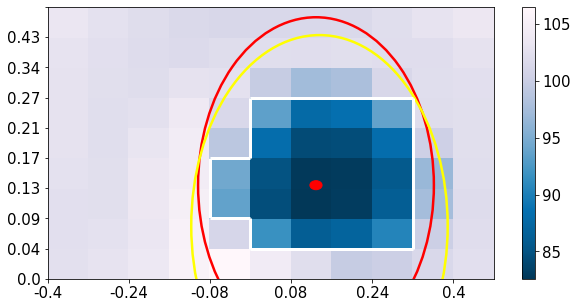

In [63]:
i = 0

x1 = history['state'][i].copy()
print(x1)
next_x1 = history['next_state'][i].copy()
next_x1[0] += env.action_space_x[int(history['action'][i][0])]
next_x1[1] += x1[5]*env.action_space_y[history['action'][i][1]]

terrain_1 = -0.0*(np.random.randint(-4, 5, no_actions[0]*no_actions[1]))/4.0

plot_heatmap_with_capture_region(x1,next_x1, terrain_1,dqs, env)

In [8]:
# This is a simulation of the episode where after taking the nth best action it checks if the IPM recovers
state = env.reset_env([0.0, 0.0, ht, v_init[0], v_init[1]], v_des, no_steps*step_time)
epi_cost = 0
history = {'state' : [], 'action' : [], 'next_state' : []}

action_number = 21

for n in range(no_steps):
    terrain = dqs.x_in[:,7:].copy()

    terrain[:,3] = 0.0*(np.random.randint(-4, 5, no_actions[0]*no_actions[1]))/4.0
    q_values, _ = dqs.predict_q(state, terrain[:,3])
    terrain[:,0] = np.reshape(q_values, (len(terrain[:,0],)))
    terrain = np.round(terrain[terrain[:,0].argsort()], 2)
    if n == 0:
        action = [int(terrain[action_number][1]),int(terrain[action_number][2]), terrain[action_number][3]] 
    else:
        action = [int(terrain[0][1]),int(terrain[0][2]), terrain[0][3]]
    next_state, cost, done = env.step_env(action, step_time)
    history['state'].append(state)
    history['action'].append(action)
    history['next_state'].append(next_state)
    print(action, cost, done, state[0:5])
    epi_cost += cost
    state = next_state
    if done:
        print('terminated ...')
        break
        
# env.show_episode(10)

[4, 3, 0.0] 1.4763405876468751 False [ 0.     0.065  0.35   0.16  -0.16 ]
[10, 3, 0.0] 4.691113686811608 False [ 0.12 -0.06  0.35  0.26  0.18]
[8, 3, -0.0] 3.9306689504516643 False [-0.15  0.07  0.35  1.2  -0.14]
[4, 2, 0.0] 0.7817576912411136 False [-0.2  -0.05  0.35  0.92  0.23]
[6, 4, -0.0] 2.0565312633736936 False [-0.02  0.06  0.35  0.17  0.03]
[3, 0, 0.0] 2.0050907337854977 False [-0.07 -0.06  0.35  0.16  0.46]
[7, 4, -0.0] 2.7750591475829807 False [ 0.09  0.01  0.35 -0.19  0.3 ]
[5, 1, -0.0] 1.057499904410931 False [-0.06 -0.09  0.35  0.29  0.52]
[5, 4, -0.0] 2.1136769236057438 False [-0.03  0.02  0.35  0.05  0.25]
[2, 0, -0.0] 3.1692409657427505 False [-0.04 -0.08  0.35 -0.13  0.54]


In [9]:
# sorted action values
state = env.reset_env([0.0, 0.0, ht, v_init[0], v_init[1]], v_des, no_steps*step_time)
terrain = dqs.x_in[:,7:].copy()
terrain[:,3] = 0.0*(np.random.randint(-4, 5, no_actions[0]*no_actions[1]))/4.0
q_values, _ = dqs.predict_q(state, terrain[:,3])
terrain[:,0] = np.reshape(q_values, (len(terrain[:,0],)))
terrain = np.round(terrain[terrain[:,0].argsort()], 2)
print(terrain[0:22])

[[82.59  6.    2.    0.  ]
 [82.72  6.    3.    0.  ]
 [82.96  7.    3.   -0.  ]
 [83.01  7.    2.    0.  ]
 [84.32  6.    4.    0.  ]
 [84.51  7.    4.    0.  ]
 [84.64  5.    2.    0.  ]
 [85.    5.    3.   -0.  ]
 [85.63  8.    3.    0.  ]
 [86.2   8.    2.    0.  ]
 [86.21  6.    1.    0.  ]
 [86.9   7.    1.    0.  ]
 [87.77  6.    5.    0.  ]
 [88.24  8.    4.   -0.  ]
 [88.28  5.    4.   -0.  ]
 [88.49  7.    5.   -0.  ]
 [90.51  8.    1.    0.  ]
 [91.71  5.    1.   -0.  ]
 [93.49  5.    5.   -0.  ]
 [93.69  4.    2.    0.  ]
 [93.75  8.    5.    0.  ]
 [94.36  4.    3.   -0.  ]]


In [14]:
## This is for the 3d capture region

# This block is to compare cpature regions with analytical capture region



def plot_heatmap_with_capture_region_3d(x1, x2, terr_1, terr_2, dqs, env):
    plt.rcParams.update({'font.size': 15})
    q_1 = dqs.predict_q(x1, terr_1)[0]
    n = dqs.no_actions
    q_mat = np.zeros((n[1], n[0]))
    for i in range(len(q_1)):
        q_mat[int(dqs.x_in[i,9]), int(dqs.x_in[i,8])] = q_1[i]
    
    fig, ax = plt.subplots(1, 2, figsize = (14,6))
    rad = infinite_capture_radius(0.2, env.action_space_x[-1], env.h)
    discretization_x = env.action_space_x[1] - env.action_space_x[0]
    discretization_y = env.action_space_y[1] - env.action_space_y[0]
    
    # shifting by 0.5 becuase all the ticks should be in the center    
    # slightly adjusted because the indices are not center aligned i
    kin_region = Ellipse((x1[0]/discretization_x , x1[1]/discretization_y),\
                            2*(np.sqrt(env.max_leg_length**2 - (env.h - env.com_offset)**2)/discretization_x),\
                         2*(np.sqrt(env.max_leg_length**2 - (env.h - env.com_offset)**2)/discretization_y), fill = False, color = 'yellow', lw = 2.5)

#     ax[0].add_patch(kin_region)
    ax[0].set_xticklabels(env.action_space_x[::2])
    ax[0].set_yticklabels(env.action_space_y)
    heatmap = ax[0].pcolor(q_mat, cmap='PuBu_r')
    ax[0].set_xlim(0,11)
    ax[0].set_ylim(0,9)
    
    ax[0].vlines(1, 1, 7, color = 'white', lw = 3)
    ax[0].vlines(5, 2, 6, color = 'white', lw = 3)
    ax[0].vlines(4, 6, 7, color = 'white', lw = 3)
    ax[0].vlines(4, 1, 2, color = 'white', lw = 3)

    ax[0].hlines(1, 1, 4, color = 'white', lw = 3 )    
    ax[0].hlines(7, 1, 4, color = 'white', lw = 3 )    
    ax[0].hlines(6, 4, 5, color = 'white', lw = 3 )    
    ax[0].hlines(2, 4, 5, color = 'white', lw = 3 )    

    
    q_2 = dqs.predict_q(x2, terr_2)[0]
    n = dqs.no_actions
    q_mat = np.zeros((n[1], n[0]))
    for i in range(len(q_2)):
        q_mat[int(dqs.x_in[i,9]), int(dqs.x_in[i,8])] = q_2[i]
    
    kin_region = Ellipse((x2[0]/discretization_x + 5., x2[1]/discretization_y),\
                            2*(np.sqrt(env.max_leg_length**2 - (env.h - env.com_offset)**2)/discretization_x),\
                         2*(np.sqrt(env.max_leg_length**2 - (env.h - env.com_offset)**2)/discretization_y), fill = False, color = 'yellow', lw = 2.5)
    
    ax[1].set_xticklabels(env.action_space_x[::2])
    ax[1].set_yticklabels(env.action_space_y)
    heatmap = ax[1].pcolor(q_mat, cmap='PuBu_r')
    ax[1].set_xlim(0,11)
    ax[1].set_ylim(0,9)
    
    ax[1].vlines(6, 1, 4, color = 'white', lw = 3)
    ax[1].vlines(7, 4, 6, color = 'white', lw = 3)
    ax[1].vlines(7, 0, 1, color = 'white', lw = 3)
    ax[1].vlines(10, 4, 5, color = 'white', lw = 3)
    ax[1].vlines(9, 5, 6, color = 'white', lw = 3)

    ax[1].vlines(11, 0, 4, color = 'white', lw = 6)

    ax[1].hlines(1, 6, 7, color = 'white', lw = 3 )    
    ax[1].hlines(4, 6, 7, color = 'white', lw = 3 )    
    ax[1].hlines(4, 10, 11, color = 'white', lw = 3 )    
    ax[1].hlines(6, 7, 9, color = 'white', lw = 3 )      
    ax[1].hlines(5, 9, 10, color = 'white', lw = 3 )    

    ax[1].hlines(0, 7, 11, color = 'white', lw = 6 )    
    
    
    fig.colorbar(heatmap, ax=ax)
    plt.show()

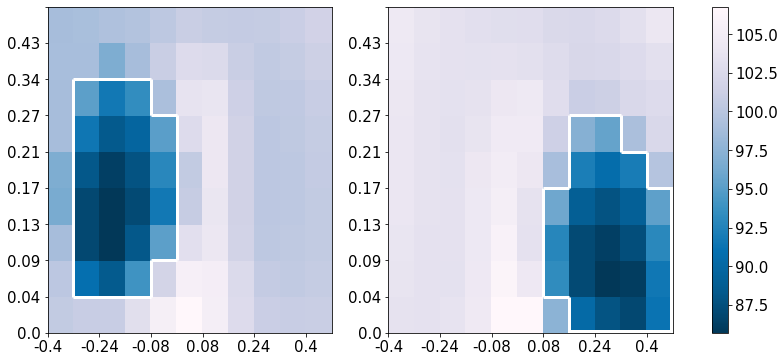

In [16]:
i = 0

x1 = [0, 0, 0.35, -0.5, 0.2, 1, 0, 0]
x2 = [0, 0, 0.35, 0.4, 0.0, 1, 0, 0]

terrain_1 = -0.05*(np.random.randint(-4, 5, no_actions[0]*no_actions[1]))/4.0
terrain_2 = 0.08*(np.random.randint(-4, 5, no_actions[0]*no_actions[1]))/4.0

plot_heatmap_with_capture_region_3d(x1, x2, terrain_1, terrain_2, dqs, env)


In [421]:
# comparison between bullet and ipm deepQ stepper
## This is for the 3d capture region

# This block is to compare cpature regions with analytical capture region
def plot_heatmap_with_capture_region_vs(x1, terr_1, dqs_1, dqs_2, env):
    plt.rcParams.update({'font.size': 15})
    q_1 = dqs.predict_q(x1, terr_1)[0]
    n = dqs_1.no_actions
    q_mat = np.zeros((n[1], n[0]))
    for i in range(len(q_1)):
        q_mat[int(dqs.x_in[i,9]), int(dqs.x_in[i,8])] = q_1[i]
    
    fig, ax = plt.subplots(1, 2, figsize = (18,8))
    rad = infinite_capture_radius(0.2, env.action_space_x[-1], env.h)
    discretization_x = env.action_space_x[1] - env.action_space_x[0]
    discretization_y = env.action_space_y[1] - env.action_space_y[0]
    
    # shifting by 0.5 becuase all the ticks should be in the center    
    # slightly adjusted because the indices are not center aligned i
    kin_region = Ellipse((x1[0]/discretization_x , x1[1]/discretization_y),\
                            2*(np.sqrt(env.max_leg_length**2 - (env.h - env.com_offset)**2)/discretization_x),\
                         2*(np.sqrt(env.max_leg_length**2 - (env.h - env.com_offset)**2)/discretization_y), fill = False, color = 'yellow', lw = 2.5)

#     ax[0].add_patch(kin_region)
    ax[0].set_xticklabels(env.action_space_x[::2])
    ax[0].set_yticklabels(env.action_space_y)
    heatmap = ax[0].pcolor(q_mat, cmap='PuBu_r')
#     ax[0].set_xlim(0,11)
#     ax[0].set_ylim(0,9)
    
#     ax[0].vlines(1, 1, 7, color = 'white', lw = 3)
#     ax[0].vlines(5, 2, 6, color = 'white', lw = 3)
#     ax[0].vlines(4, 6, 7, color = 'white', lw = 3)
#     ax[0].vlines(4, 1, 2, color = 'white', lw = 3)

#     ax[0].hlines(1, 1, 4, color = 'white', lw = 3 )    
#     ax[0].hlines(7, 1, 4, color = 'white', lw = 3 )    
#     ax[0].hlines(6, 4, 5, color = 'white', lw = 3 )    
#     ax[0].hlines(2, 4, 5, color = 'white', lw = 3 )    

    
    q_2 = dqs_2.predict_q(x1, terr_1)[0]
    n = dqs_2.no_actions
    q_mat = np.zeros((n[1], n[0]))
    for i in range(len(q_2)):
        q_mat[int(dqs.x_in[i,9]), int(dqs.x_in[i,8])] = q_2[i]
    
    kin_region = Ellipse((x2[0]/discretization_x + 5., x2[1]/discretization_y),\
                            2*(np.sqrt(env.max_leg_length**2 - (env.h - env.com_offset)**2)/discretization_x),\
                         2*(np.sqrt(env.max_leg_length**2 - (env.h - env.com_offset)**2)/discretization_y), fill = False, color = 'yellow', lw = 2.5)
    
    ax[1].set_xticklabels(env.action_space_x[::2])
    ax[1].set_yticklabels(env.action_space_y)
    heatmap = ax[1].pcolor(q_mat, cmap='PuBu_r')
    ax[1].set_xlim(0,11)
    ax[1].set_ylim(0,9)
    
#     ax[1].vlines(6, 1, 4, color = 'white', lw = 3)
#     ax[1].vlines(7, 4, 6, color = 'white', lw = 3)
#     ax[1].vlines(7, 0, 1, color = 'white', lw = 3)
#     ax[1].vlines(10, 4, 5, color = 'white', lw = 3)
#     ax[1].vlines(9, 5, 6, color = 'white', lw = 3)

#     ax[1].vlines(11, 0, 4, color = 'white', lw = 6)

#     ax[1].hlines(1, 6, 7, color = 'white', lw = 3 )    
#     ax[1].hlines(4, 6, 7, color = 'white', lw = 3 )    
#     ax[1].hlines(4, 10, 11, color = 'white', lw = 3 )    
#     ax[1].hlines(6, 7, 9, color = 'white', lw = 3 )      
#     ax[1].hlines(5, 9, 10, color = 'white', lw = 3 )    

#     ax[1].hlines(0, 7, 11, color = 'white', lw = 6 )    
    
    
    fig.colorbar(heatmap, ax=ax)
    plt.show()


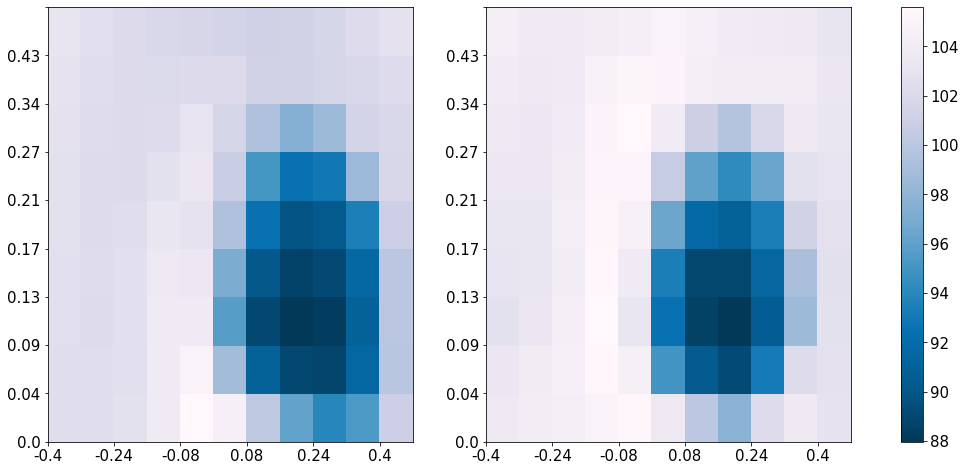

In [434]:
dqs_ipm = DQStepper(lr=1e-4, gamma=0.98, use_tarnet= True, no_actions= no_actions, trained_model='../../models/dqs_11_9')
dqs_bullet = DQStepper(lr=1e-4, gamma=0.98, use_tarnet= True, no_actions= no_actions, trained_model='../../models/dqs_1_light')

x1 = [0.0, 0.02, 0.34, 0.3, 0.0, 1, 0.0, 0]

terrain_1 = -0.00*(np.random.randint(-4, 5, no_actions[0]*no_actions[1]))/4.0

plot_heatmap_with_capture_region_vs(x1, terrain_1, dqs_ipm, dqs_bullet, env)

